# Demo 1 Curve fitting

## 1.1 - Modèle à 1 paramètre

Cette démo consiste à lire les données du fichier demo1_data.csv, de les afficher sur un graphique et finalement de développer un modèle et d'en faire le fit numérique.

Le fichier .csv est structuré selon

|x|y1|y2|y3|y4|y5|
|---|---|---|---|---|---|
|0|...|...|...|...|...|
|0.05|...|...|...|...|...|
|0.1|...|...|...|...|...|
|...|...|...|...|...|...|
|1|...|...|...|...|...|

où les colones `y1` à `y5` représentent différentes observation de la même valeur (pensez bruit dans une mesure expérimentale par exemple).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Étape 1 - loading data

La première étape est de lire les valeurs `x` dans un vecteur et les valeurs y1-y5 dans une matrice `Y` (ce sera utile plus tard). Nous avons plusieurs choix, voyons-en quelques-uns pour vous donner des idées.

#### Méthode *built-in*
Comment faire sans aucunes libraries additionnelle? C'est long et je ne recommande pas, mais une bonne pratique.

In [2]:
file = 'data/demo1_data.csv'
fh = open(file)

# We create empty lists to put data in as we read it
x = []
Y = [[],[],[],[],[]]

fh.readline() # We read the first line (the one with the column names) BEFORE the loop

for line in fh.readlines():
    line = line.strip() # this removes the \n (newline) characters
    line = line.split(',') # We split the lines with a ',' character
    x.append(float(line[0])) # We add the x data from the line to the x list
    
    # We add the 5 y datas to Y
    for i in range(len(Y)):
        Y[i].append(float(line[i+1]))
#     print(line)
    
fh.close()

# We now convert x and Y to numpy arrays
x = np.array(x)
Y = np.array(Y)

#### Pandas

Pandas possède des fonctions pour lire presque tous les types de fichier avec lesquels vous travaillez normalement (dont .xlsx!)

In [3]:
file = 'data/demo1_data.csv'
data = pd.read_csv(file, delimiter=',')
data.head()

# We now convert x and Y to numpy arrays
x = data.x.to_numpy()
Y = data.loc[:, ['y1', 'y2', 'y3', 'y4', 'y5']].to_numpy()

#### Numpy
Le plus simple ici est par contre de directement utiliser numpy.

In [4]:
file = 'data/demo1_data.csv'
data = np.genfromtxt(file, delimiter=',', skip_header=1)

x = data[:, 0]
Y = data[:, 1:]

### Étape 2 - Graphique

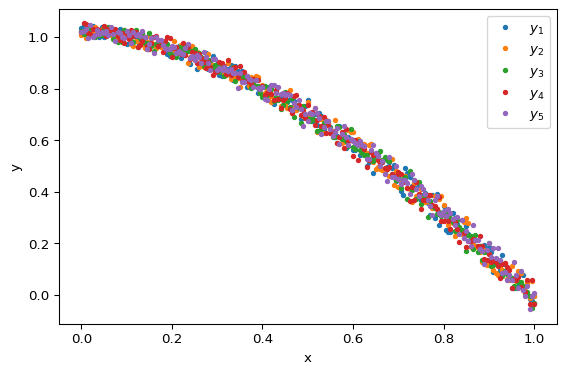

In [5]:
plt.figure(dpi=96)

for i, y in enumerate(Y.T):
    plt.plot(x, y, '.', label='$y_{}$'.format(i+1))

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()

### Étape 3 - Mean et Std

Il est judicieux ici (vu les données) de faire le fit sur la moyenne entre les y (pour chaque x)

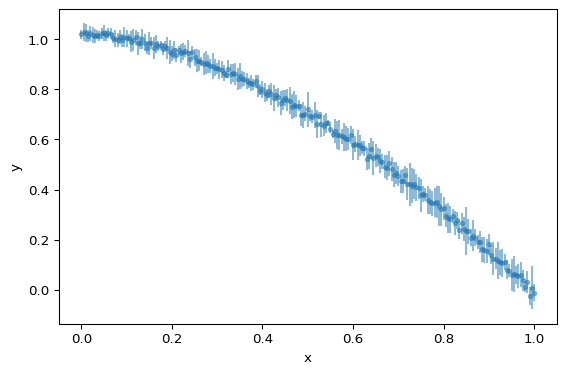

In [6]:
y_mean = Y.mean(axis=1)
y_std = Y.std(axis=1)

# newplot
plt.figure(dpi=96)
plt.errorbar(x, y=y_mean, yerr=2*y_std, fmt='.', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()

### Étape 4 - Model and fit

Pour faire le fit de notre modèle, nous allons utiliser la fonction `curve_fit` de scipy. Comme nous n'avons besoin que de cette fonction, il est inutile d'importer scipy au complet. Nous aurons aussi besoin de spécifier notre modèle comme une fonction. J'utilise une lambda function ici, mais une fonction *normale* fonctionnerait aussi. Je sais (j'ai généré les données moi même hehehe) qu'un bon modèle ici serait

$$
f_\phi(x) = 1-x^\phi
$$

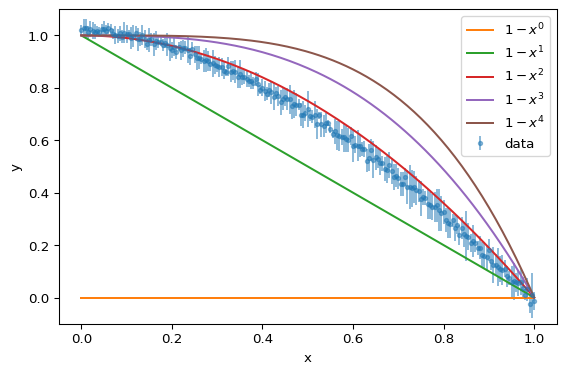

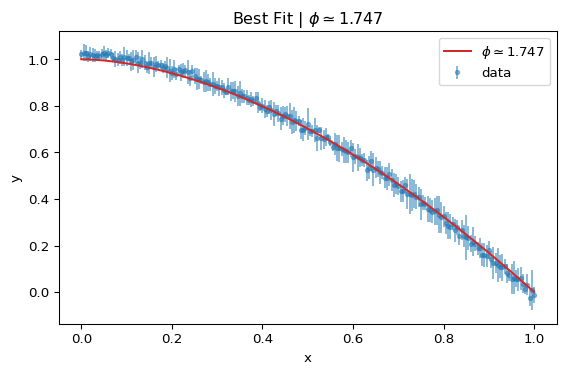

In [7]:
# Parametrized model
f = lambda x, phi: 1-x**phi

# Before fitting, let's try different values of phi
plt.figure(dpi=96)
plt.errorbar(x, y=y_mean, yerr=2*y_std, fmt='.', alpha=0.5, label='data')
for phi in range(5):
    plt.plot(x, f(x, phi),
             label='$1-x^{}$'.format(phi))
    
plt.ylim([-0.1, 1.1])
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
# Based on initial results, 1<phi<2 looks like a good model

# Now we fit with scipy
from scipy.optimize import curve_fit
coeff, cov = curve_fit(f, x, y_mean)

# The fitted model is
y_fit = f(x, coeff[0])

# let's plot it

plt.figure(dpi=96)
plt.errorbar(x, y=y_mean, yerr=2*y_std, fmt='.', alpha=0.5, label='data')
plt.plot(x, y_fit, label='$\phi \simeq {:.3f}$'.format(coeff[0]),
        color='tab:red', zorder=3)


plt.title('Best Fit | $\phi \simeq {:.3f}$'.format(coeff[0]))
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()

## 1.2 Modèle à plusieurs paramètres

Dans cet exemple, nous verrons comment faire le curvefit d'un modèle à plusieurs paramètres en utilisant encore la fonction `curve_fit()` de `scipy`.

### Étape 1 - génération de donnée

Plutôt que de lire des données à partir d'un fichier, nous allons ici générer nos propres données. Nous pourrons ainsi comparer facilement les paramètres de génération et ceux obtenus par le curvefit. Utilisons un modèle gaussien de la forme

$$
f_{a,b,c}(x) = a\cdot \exp\left(-\frac{(x-b)^2}{2c^2}\right)
$$

Pour l'exemple, prennons $a=2.31$, $b=-0.27$ et $c=0.36$

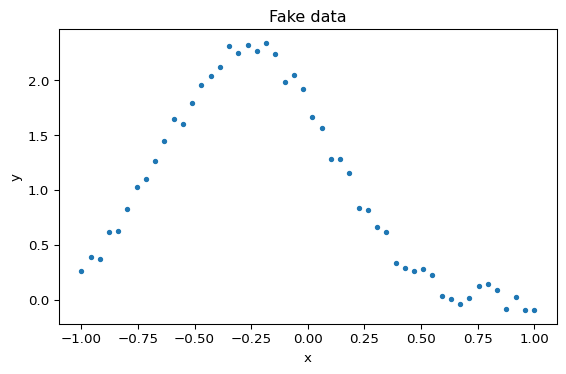

In [8]:
# Data parameters
a = 2.31
b = -0.27
c = 0.36
noise_level = 0.1 # higher noise level makes fit harder (you can play with this)

# Fake data generation
nbins = 50 # number of points on x axis
x = np.linspace(-1, 1, nbins) # range for x is just an example and can be different
y_data = a*(np.exp(-(x-b)**2/2/c**2) + noise_level*(np.random.rand(x.size)-0.5))

# Fake data plot
plt.figure(dpi=96)
plt.plot(x, y_data, '.')
plt.title('Fake data')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()

### Étape 2 - Modèle et fit

Comme précédement, nous utiliserons curve_fit de scipy pour faire le fit de notre modèle. Par contre, nous utiliserons ici une fonction (plustot qu'une lambda function) pour définir notre modèle. Les paramètres d'entrés de cette fonction seront `x` et `\*p`. `x` est comme précédement la variable indépendente de notre modèle et doit toujours être le premier argument de notre fonction (suivant la convention de `curve_fit()`). `\*p` est un non-keyword Arguments nous permettant de passer autant d'argument que l'on veut à la fonction sans avoir à les spécifier dans notre définition. Dans cet exemple, `*p` est unpacked en `a`, `b` et `c`. Ensuite, nous devons aussi maintenant spécifier à `curve_fit()` des paramètres de départ à essayer. Selon notre modèle, $a=1$, $b=0$  et $c=1$ semble un bon choix de départ.

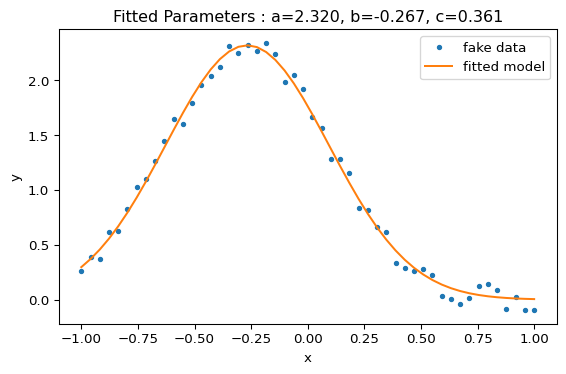

In [9]:
# Define model function to be used to fit to the data above:
def gauss(x, *p):
    a, b, c = p
    y = a*np.exp(-(x-b)**2/2/c**2)
    return y

# p0 is the initial guess for the fitting coefficients (a, b and c above)
p0 = [1, 1, 1]

coeff, var_matrix = curve_fit(gauss, x, y_data, p0=p0)
a_fit, b_fit, c_fit = coeff

# Get the fitted curve
fit = gauss(x, *coeff)

# Printing results
plt.figure(dpi=96)
plt.plot(x, y_data, '.', label='fake data')
plt.plot(x, fit, label='fitted model')

plt.title('Fitted Parameters : a={:.3f}, b={:.3f}, c={:.3f}'.format(*coeff))
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()